In [17]:
# %load trainer.py
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torchsummary

In [18]:

DOWNLOAD_MNIST = True   #第一次用要先下載data,所以是True

# prepare dataset

train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_data = torchvision.datasets.MNIST(
    root='./mnist',
    train=True,
    transform=train_transform,
    download=DOWNLOAD_MNIST
)

test_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=False,
    transform=test_transform,
    download=DOWNLOAD_MNIST,
)

In [19]:

# # Check dataset shape
# train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=1, shuffle=True)

# # Visualize one resized image
# example_image, example_label = next(iter(train_loader))
# # print(f"Image shape: {example_image.shape}")  # Should be (1, 1, 32, 32)

# print(test_data.test_data.size())





In [ ]:
import torchvision
import torch.nn as nn
import torchsummary
#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 10

# 原始 VGG16 模型
model = torchvision.models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False
# 修改輸入通道數
model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# 插入 Batch Normalization
new_features = []
for layer in model.features:
    new_features.append(layer)
    if isinstance(layer, nn.Conv2d):  # 在每個卷積層後加 BN
        new_features.append(nn.BatchNorm2d(layer.out_channels))

# 替換原有的 features 模組
model.features = nn.Sequential(*new_features)

# 修改輸出層
model.classifier._modules['6'] = nn.Linear(model.classifier[6].in_features, num_classes)
# 移動模型到 GPU (若可用)
model = model.to(device)


# 查看模型結構
torchsummary.summary(model, (1, 32, 32))

d:\Course\DataScience\testenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Course\DataScience\testenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [21]:
#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

print(f"using device: {device}")
EPOCH = 40
lr = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Initialize lists to save metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Variable to track the best accuracy
best_accuracy = 0.0

# Train the model
for epoch in range(EPOCH):
    model.train()  # Set model to training mode
    train_loss = 0.0
    total_train = 0
    correct_train = 0

    for images, labels in train_loader:
        # No need for Variable, tensors work directly
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item() * images.size(0)  # Accumulate batch loss

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train

    # Evaluate the model on the validation set
    model.eval()  # Set model to evaluation mode
    valid_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():  # Disable gradient computation for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU if available

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)  # Accumulate batch loss

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    valid_loss /= len(test_loader.dataset)
    valid_accuracy = 100 * correct_test / total_test

    # Save metrics for the current epoch
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    # Output training and testing results
    print(f"Epoch [{epoch+1}/{EPOCH}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%\n")

    # Save the best model based on validation accuracy
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        torch.save(model.state_dict(), 'best_model.ckpt')
        print(f"Best model saved with accuracy: {best_accuracy:.2f}%")

# Print final results
print("Training Losses:", train_losses)
print("Validation Losses:", valid_losses)
print("Training Accuracies:", train_accuracies)
print("Validation Accuracies:", valid_accuracies)

using device: cuda


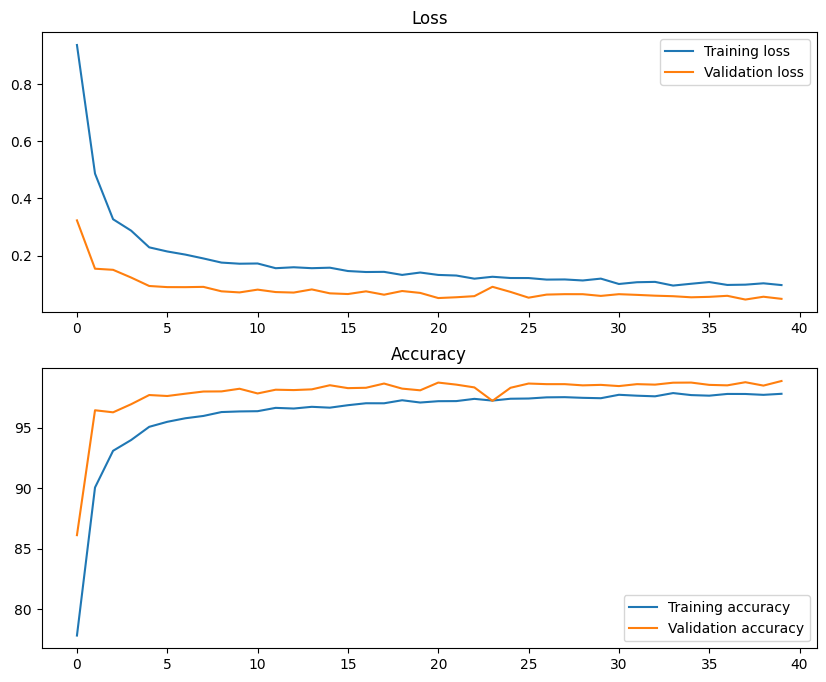

In [ ]:
# 建立畫布
plt.figure(figsize=(10, 8))
#plot loss
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.title('Loss')
plt.legend()
# plt.show()

#plot accuracy
plt.subplot(2, 1, 2)
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(valid_accuracies, label='Validation accuracy')
plt.title('Accuracy')
plt.legend()    
plt.show()